<img src = 'Data/poule.png' />

<h1><center><font color='red'> Etude de marché pour un développement à l'international </font></center></h1>

* [Importation des librairies et création de fonctions](#chapter1)
* [Importation du Dataframe](#chapter2)
* [Création de la matrice des données et normalisation des données](#chapter3)
* [ACP](#chapter4)
    * [Cercle des corrélations](#section4_2)
* [Classification Ascendante Hiérarchique](#chapter5)
    * [Analyse statistique](#section5_2)
* [Algorithme du k-means](#chapter6)
    * [Inertie du modèle](#section6_1)
    * [Coefficient de silhouette](#section6_2)  
    * [Projection des centroides et des individus par cluster](#section6_3)
    * [Analyse statistique](#section6_4)
* [Comparaison des résultats](#chapter7)
    * [Analyse des sous-groupes](#section7_2)
* [Projection sur les plans factoriels](#chapter8)
    * [Projection des 5 clusters](#section8_1)
    * [Projection des 2 sous-groupes](#section8_2)
* [Création de cartes](#chapter9)

# Importation des librairies et création de fonctions <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
from sklearn import preprocessing, cluster, metrics, decomposition
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# intègre les objets python dans des cellules markdown
from IPython.display import Markdown as md

In [12]:
def infosurdf(df):
    d1 = pd.DataFrame(df.dtypes).T.rename(index={0: "type de la colonne"})
    d2 = pd.DataFrame(df.isnull().sum()).T.rename(index={0: "nombre de valeurs NaN"})
    d3 = pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0: "valeurs nulles en %"})
    d4 = pd.DataFrame(df.nunique()).T.rename(index={0: "nombre de valeurs uniques"})
    d5 = pd.DataFrame(df.count()).T.rename(index={0: "nombre de valeurs totales"})
    return pd.concat([d1, d2, d3, d4, d5])

# merci à Nicolas Rangeon

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(pcs[d1, :]), min(pcs[d2, :]), max(pcs[d2, :])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1, :], pcs[d2, :], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0, 0],[x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1), fontsize=16, fontweight='bold')
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure       
            fig = plt.figure(figsize=(7, 6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:,[d1, d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='10', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1), fontsize=16, fontweight='bold')
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    # critère de Kaiser
    p = len(df_acp.columns)
    kaiser = 100 / p
        
    plt.figure(figsize=(15, 10))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.axhline(y=kaiser, color='red', linestyle='--')
    plt.xticks(np.arange(len(scree))+1)
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres", fontsize=16, fontweight='bold')
    plt.show(block=False)
    scree_cum = (pca.explained_variance_ratio_*100).cumsum()
    scree_cum = pd.DataFrame(data=scree_cum, index=np.arange(len(scree))+1, columns=['Cumul de variance expliquée']).T
    print(scree_cum)
    
    
def plot_dendrogram(Z, names, orient):
    plt.figure(figsize=(10, 25))
    plt.title('Classification Ascendante Hiérarchique', fontsize=16, fontweight='bold')
    plt.xlabel('distance')
    dendrogram(Z, labels = names, orientation = orient, leaf_font_size=10, color_threshold=14)
    plt.show()

# Importation du df<a class="anchor" id="chapter2"></a>

In [3]:
df = pd.read_csv('Data/Pollo.csv')
df = df.set_index('Zone')
df

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Production
Zone,,,,,,,,,,,
Afghanistan,2058.4,-2.80,5.63,3.629611e+07,2.58,0.54,10.7,0.0,29.0,1.00,28.0
Angola,7310.9,-0.33,9.23,2.981677e+07,3.38,3.60,15.7,0.0,277.0,1.12,42.0
Albanie,12771.0,0.38,1.10,2.884169e+06,-0.08,6.26,62.7,0.0,38.0,0.94,13.0
Émirats arabes unis,67183.6,0.62,3.28,9.487203e+06,1.35,14.80,50.7,94.0,433.0,1.64,48.0
Argentine,23597.1,0.17,6.88,4.393714e+07,0.99,13.53,67.3,207.0,8.0,1.86,2161.0
...,...,...,...,...,...,...,...,...,...,...,...
"Chine, continentale",14621.2,0.00,2.47,1.421022e+09,0.49,3.96,40.3,576.0,452.0,1.86,18236.0
Cuba,21016.6,0.65,8.83,1.133925e+07,0.04,7.12,33.0,0.0,312.0,0.95,29.0
Pérou,12506.5,-0.26,0.66,3.144430e+07,1.68,6.71,29.0,2.0,60.0,1.15,1465.0


## Vérification du df
types des colonnes, présence de valeurs manquantes

In [4]:
infosurdf(df)

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Production
type de la colonne,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nombre de valeurs NaN,0,0,0,0,0,0,0,0,0,0,0
valeurs nulles en %,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nombre de valeurs uniques,154,123,122,154,126,148,112,50,83,116,117
nombre de valeurs totales,154,154,154,154,154,154,154,154,154,154,154


In [5]:
df.describe()

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Production
count,154.000000,154.000000,154.000000,1.540000e+02,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,20674.967532,-0.074026,5.545130,4.503270e+07,1.242857,7.202078,37.003247,115.623377,97.266234,1.862597,762.389610
std,21042.076998,0.920936,4.582071,1.603948e+08,1.138705,5.397194,20.863075,482.856236,194.158854,1.090797,2604.055508
min,912.800000,-2.940000,0.000000,5.204500e+04,-1.530000,0.040000,6.000000,0.000000,0.000000,0.400000,0.000000
25%,4869.025000,-0.647500,1.480000,2.926834e+06,0.382500,2.452500,18.700000,0.000000,4.000000,1.095000,14.250000
50%,13671.750000,0.035000,3.915000,1.009671e+07,1.135000,6.945000,35.500000,1.000000,20.500000,1.610000,70.000000
75%,28970.550000,0.650000,9.045000,3.268696e+07,2.107500,10.280000,52.300000,19.250000,95.000000,2.347500,445.250000
max,126184.000000,1.430000,18.690000,1.421022e+09,4.170000,25.100000,103.000000,4223.000000,1069.000000,7.310000,21914.000000


# Création de la matrice des données et normalisation des données<a class="anchor" id="chapter3"></a>

In [6]:
# création d'un tableau numpy 2D
X = df.values
# les index sont stockés dans un objet names
names = df.index
# forme de l'array
X.shape

(154, 11)

In [7]:
# création de l'objet standardiseur
scaler = preprocessing.StandardScaler()
# calcul des données transformées
X_scaled = scaler.fit_transform(X)

# Analyse en composantes principales <a class="anchor" id="chapter4"></a>

Notre dataframe contient 11 variables. La corrélation entre certaines de ces variables peut amener des pb de multicolinéarité.<br>A l'aide d'une ACP, nous allons réduire la dimensionnalité de cet ensemble pour trouver sa dimension intrinsèque.

In [8]:
# création de l'objet PCA (11 composantes)
pca = decomposition.PCA()
# application de l'ACP aux données standardisées
pca.fit(X_scaled)

PCA()

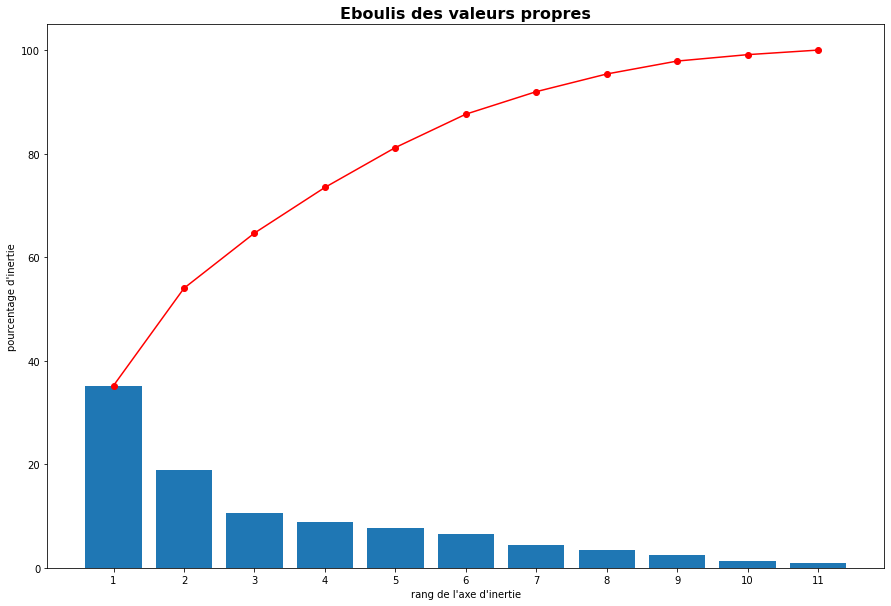

                                    1          2         3          4   \
Cumul de variance expliquée  35.205587  54.002712  64.65354  73.471678   

                                    5          6          7          8   \
Cumul de variance expliquée  81.174333  87.621046  91.971792  95.382995   

                                    9          10     11  
Cumul de variance expliquée  97.880517  99.118258  100.0  


In [9]:
display_scree_plot(pca)

In [11]:
# critère de Kaiser
p = len(df.columns)
kaiser = 100 / p
print(round(kaiser,2), "%") # critère à vérifier

9.09 %


Les 6 premières CP expliquent 87% de la variance totale des données. Nous pouvons donc dire que la dimension intrinsèque de cet ensemble de données est raisonnablement égale à 6.<br> Transformons le df initial à 11 variables en un df à 6 variables.

In [10]:
# création de l'objet PCA (6 composantes)
pca6 = decomposition.PCA(n_components=6)
# application de l'ACP aux données standardisées
X_trans = pca6.fit_transform(X_scaled)
# création d'un Dataframe à 6 variables
df_trans = pd.DataFrame(X_trans, index=names, columns=['1e CP', '2e CP', '3e CP', '4e CP', '5e CP', '6e CP'])
df_trans

,1e CP,2e CP,3e CP,4e CP,5e CP,6e CP
Zone,,,,,,
Afghanistan,-3.199929,0.776236,-0.903069,-0.418941,-0.031786,-1.021538
Angola,-1.994780,0.250781,-0.422165,-0.464623,-1.599091,0.089162
Albanie,0.877907,-0.824376,-1.046089,0.413221,1.304401,-0.119712
Émirats arabes unis,2.371609,-0.733396,-0.798232,-0.614943,-1.678132,0.244935
Argentine,1.297998,0.032950,0.383324,1.020686,0.015964,0.357278
...,...,...,...,...,...,...
"Chine, continentale",2.221762,9.266682,-0.644796,-2.896520,2.456895,3.577618
Cuba,0.291396,-0.492418,-0.897101,0.339306,-0.338903,1.114546
Pérou,-0.427233,0.100442,-0.836956,-0.101724,0.421443,-0.603998


## Cercle des corrélations <a class="anchor" id="section4_2"></a>

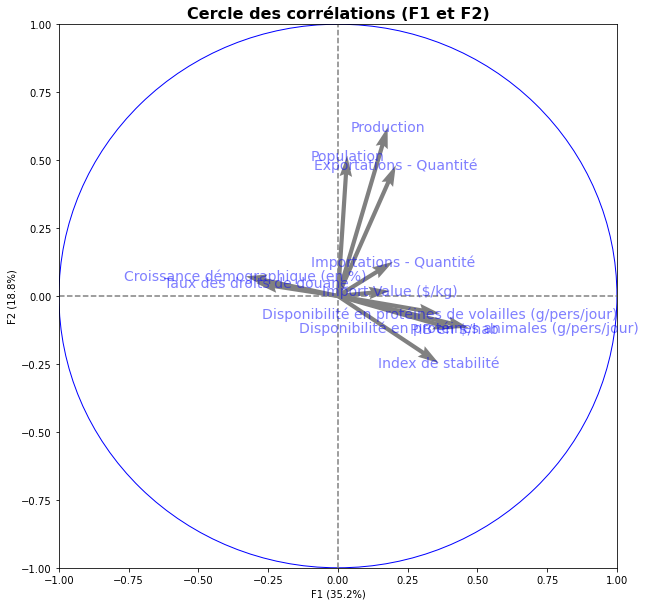

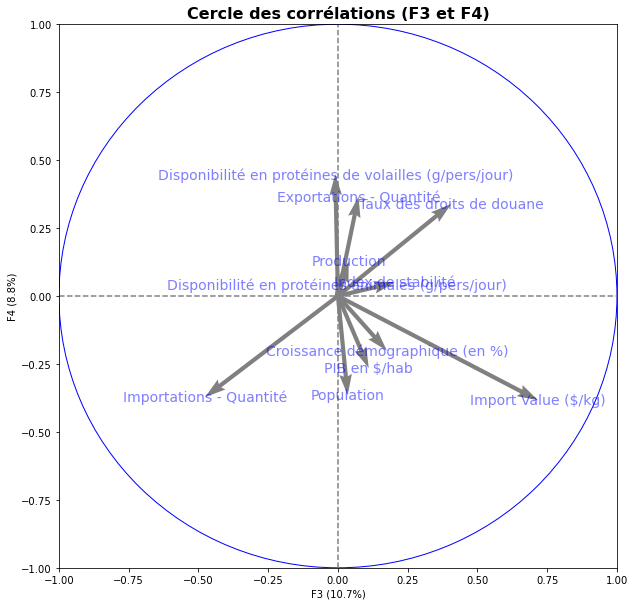

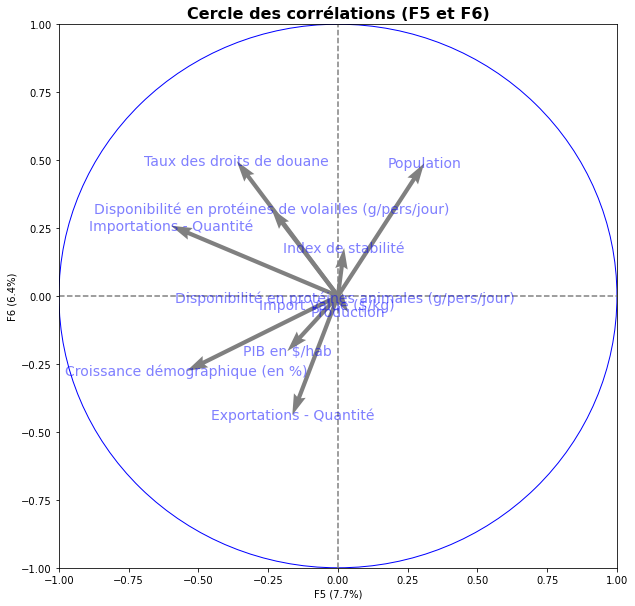

In [11]:
# calcul des différentes composantes
pcs = pca6.components_
#nombre de composantes principales retenues
n_comp = 6

display_circles(pcs, n_comp, pca6, [(0, 1), (2, 3), (4, 5)], labels = np.array(df.columns))

Analyse des cercles:

Les variables avec une contribution négative à la 1e CP correspondent à celles dont le taux doit être le plus faible possible : la croissance démographique et les frais de douanes. Nous cherchons effectivement à nous implanter dans des pays aux frais de douane faibles pour minimiser les couts. Les autres variables ont un effet positif, 4 avec un effet plus marqué : le PIB/habitant, l'index de stabilité et les apports en protéine. Comme vu dans la partie préparatoire, il y a une corrélation entre PIB et consommation de viande. Les fortes valeurs de la 1e CP caractérisent les pays stables et riches où la consommation de viande est importante.

La 2e CP est impacté fortement par la population, la production et les exportations, elle caractérise donc l'auto-suffisance, minimisée par une stabilité politique basse.
 
La 3e CP est influencée positivement par le prix au kg à l'Import et les taux de douane et négativement par la quantité importée, cette CP caractérise les aspects financiers.

La 4e CP est influencée positivement par la Disponibilité en protéines de volailles, les exportations et les taux de droits de douane (variables que nous voulons les plus faibles possibles) et négativement par la population, les importations et leur valeur (que nous voulons plus fortes). Cette composante devra donc être la plus petite possible

La 5e CP est influencée positivement par la population et négativement par les autres variables.

La 6e CP est influencée positivement par la population et les taux des droits de douane et négativement par les exportations.

# Classification Ascendante hiérarchique <a class="anchor" id="chapter5"></a>

méthode de Ward : on regroupe les classes afin que l'augmentation de l'inertie interclasse soit maximale, ou, ce qui revient au même d'après le théorème de Huygens, afin que l'augmentation de l'inertie intraclasse soit minimale.

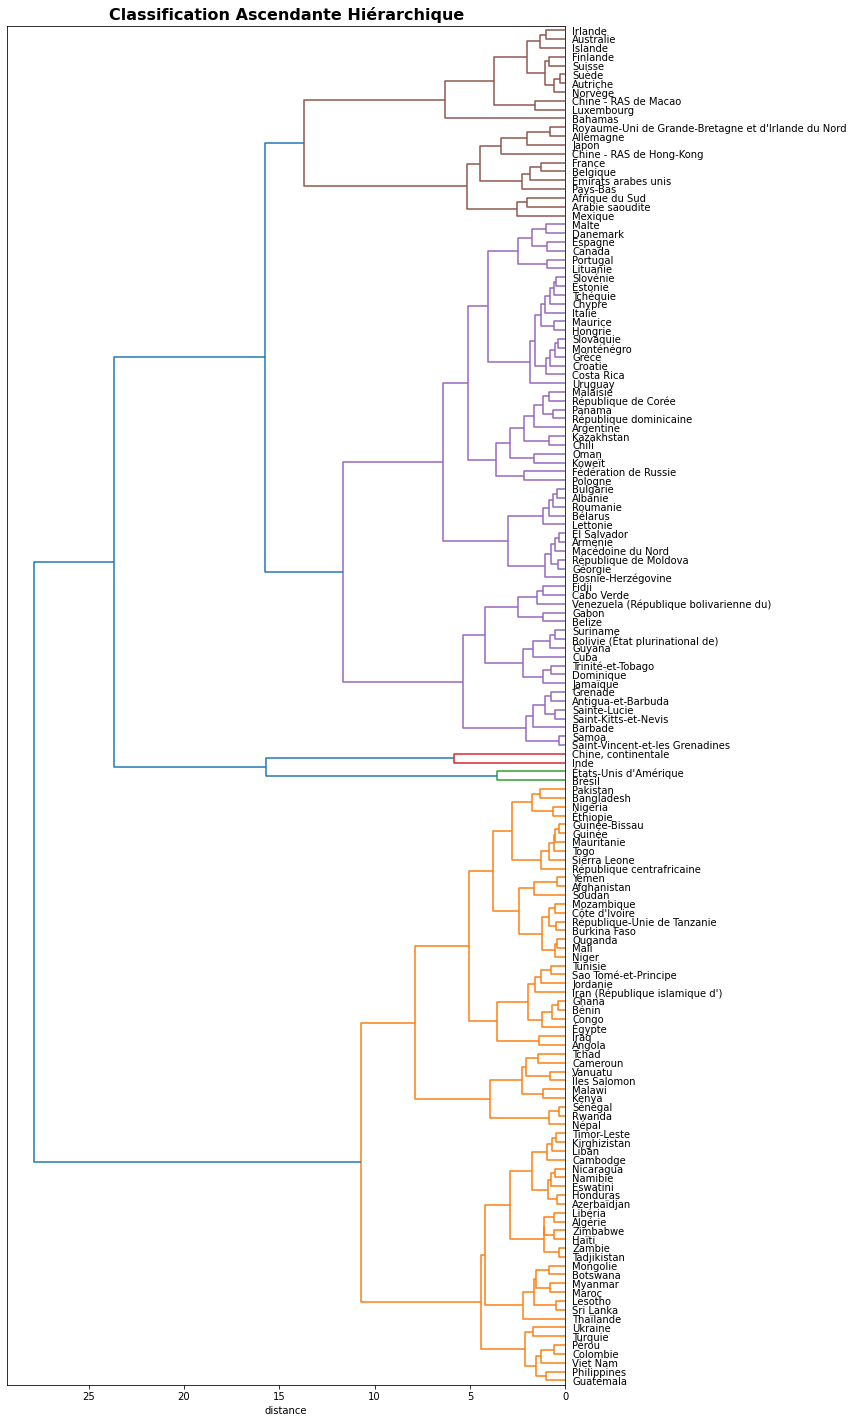

In [12]:
Z = linkage(X_trans, 'ward')

plot_dendrogram(Z, names, 'left')

Nous obtenons 5 clusters de différentes tailles :

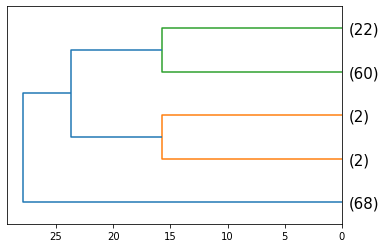

In [13]:
dendrogram(Z, p=5, truncate_mode='lastp', leaf_font_size=15, orientation='left');

Nous récupérons les clusters ainsi créés et les implémentons dans notre df initial.

In [14]:
clusters = fcluster(Z, 5, criterion='maxclust')
df['Cluster CAH'] = clusters
df

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Production,Cluster CAH
Zone,,,,,,,,,,,,
Afghanistan,2058.4,-2.80,5.63,3.629611e+07,2.58,0.54,10.7,0.0,29.0,1.00,28.0,1
Angola,7310.9,-0.33,9.23,2.981677e+07,3.38,3.60,15.7,0.0,277.0,1.12,42.0,1
Albanie,12771.0,0.38,1.10,2.884169e+06,-0.08,6.26,62.7,0.0,38.0,0.94,13.0,4
Émirats arabes unis,67183.6,0.62,3.28,9.487203e+06,1.35,14.80,50.7,94.0,433.0,1.64,48.0,5
Argentine,23597.1,0.17,6.88,4.393714e+07,0.99,13.53,67.3,207.0,8.0,1.86,2161.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
"Chine, continentale",14621.2,0.00,2.47,1.421022e+09,0.49,3.96,40.3,576.0,452.0,1.86,18236.0,3
Cuba,21016.6,0.65,8.83,1.133925e+07,0.04,7.12,33.0,0.0,312.0,0.95,29.0,4
Pérou,12506.5,-0.26,0.66,3.144430e+07,1.68,6.71,29.0,2.0,60.0,1.15,1465.0,1


Nous pouvons maintenant regroupé les pays par cluster.<br> Nous ajoutons 2 colonnes pour notre analyse : 
>le "ratio prot" nous donne un aperçu de la consommation de volailles, plus ce ratio est élevé plus les pays du cluster consomment de la viande de volailles,<br>le ratio Import/Export nous renseigne sur la dépendance aux importations.

In [15]:
CAH_df = df.groupby('Cluster CAH').mean()
# création d'une colonne ratio des apports en protéines
CAH_df['Ratio prot'] = CAH_df['Disponibilité en protéines de volailles (g/pers/jour)'] / CAH_df['Disponibilité en protéines animales (g/pers/jour)']
# création d'une colonne ratio Import/Export
CAH_df['Ratio Import/Export'] = CAH_df['Importations - Quantité'] / CAH_df['Exportations - Quantité']
CAH_df

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Production,Ratio prot,Ratio Import/Export
Cluster CAH,,,,,,,,,,,,,
1,6210.142647,-0.739706,7.200294,3.318517e+07,2.076324,3.069853,19.219118,23.558824,42.102941,1.623235,308.882353,0.159729,1.787141
2,37317.150000,-0.040000,4.965000,2.664593e+08,0.725000,17.805000,62.700000,3957.500000,63.000000,3.020000,18057.500000,0.283971,0.015919
3,10402.050000,-0.380000,4.330000,1.379849e+09,0.780000,2.355000,27.150000,290.000000,226.000000,3.040000,10890.500000,0.086740,0.779310
4,23754.558333,0.394667,4.872000,1.191193e+07,0.445000,10.368333,47.105000,50.450000,56.833333,1.661167,367.066667,0.220111,1.126528
5,56406.518182,0.730000,2.428182,3.050504e+07,0.931818,10.815909,62.981818,212.818182,369.454545,2.939545,749.272727,0.171731,1.736010


Ces données, une fois normalisées, peuvent être visualisés sur une heatmap

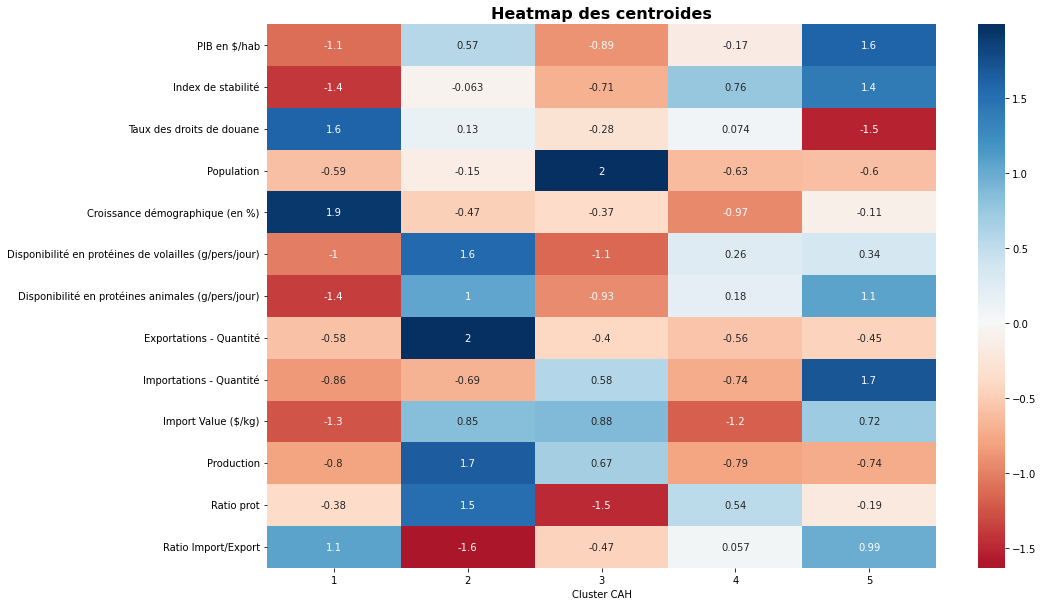

In [16]:
# les données sont centrées et réduites
CAH_scaled = scaler.fit_transform(CAH_df)
CAH_scaled = pd.DataFrame(CAH_scaled, index=CAH_df.index, columns=CAH_df.columns).T

fig = plt.figure(figsize=(15, 10))
sns.heatmap(CAH_scaled, center=0, cmap='RdBu', annot=True)
plt.title('Heatmap des centroides', fontsize=16, fontweight='bold');

Les numéros de clusters sont affectés aléatoirement, nous les stockons dans des variables pour les intégrer automatiquement à notre analyse.

In [17]:
clusterCAH1 = CAH_df.index[CAH_df['PIB en $/hab'] == min(CAH_df['PIB en $/hab'])][0]
clusterCAH2 = CAH_df.index[CAH_df['Population'] == max(CAH_df['Population'])][0]
clusterCAH3 = CAH_df.index[CAH_df['Exportations - Quantité'] == max(CAH_df['Exportations - Quantité'])][0]
clusterCAH4 = CAH_df.index[CAH_df['Population'] == min(CAH_df['Population'])][0]
retenuCAH = CAH_df.index[CAH_df['Importations - Quantité'] == max(CAH_df['Importations - Quantité'])][0]

Chaque groupe présente un maximum et un minimum dans des variables différentes ce qui permet de les caractériser globalement.

<u>Analyse des clusters :</u> 

cluster {{clusterCAH1}} : pays en voie de développement à la stabilité politique basse et à la croissance démographique forte. Les frais de douane y sont élevés et le prix à l'import est le plus faible. La demande en viande de volailles pourrait y être forte (production faible, forte dépendance aux importations) mais les difficultés économiques écartent ces pays pour nos exportations.

cluster {{clusterCAH2}} : l'Inde et la Chine (population supérieure à 1 Milliard). La consommation de volailles y est faible.

cluster {{clusterCAH3}} : Les EUA et le Brésil, pays producteurs de volaille (dépendance aux importations très faible) avec une forte exportation.

cluster {{clusterCAH4}} : petits pays stables avec un PBI élevé. Importent quasiment autant qu'ils exportent et à faible prix.

cluster {{retenuCAH}} : pays riches et stables politiquement avec une forte dépendance aux importations et à un prix élevé. Les taux de douanes sont faibles, ce sont les pays de ce cluster que nous devons cibler.
Ce cluster contient la France, qui nous a servi de pays-référence.

<Figure size 1080x720 with 0 Axes>

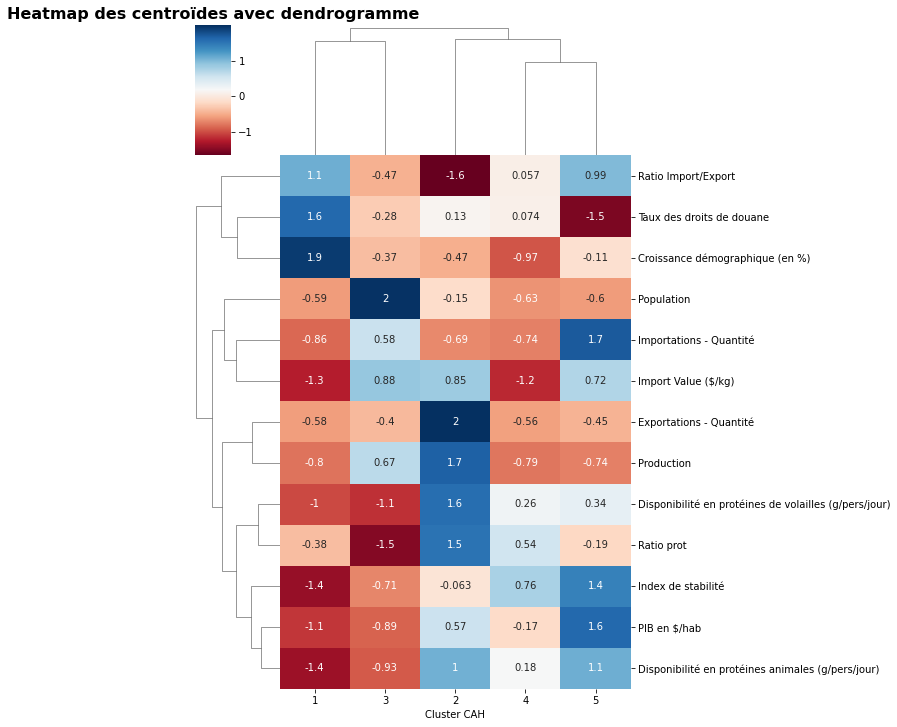

In [18]:
fig = plt.figure(figsize=(15,10))
sns.clustermap(CAH_scaled, cmap='RdBu', annot=True)
plt.title('Heatmap des centroïdes avec dendrogramme', fontsize=16, fontweight='bold');

Les clusters {{retenuCAH}} et {{clusterCAH4}} sont très proches et regroupent des pays developpés. Nous rapprochons ensuite le groupe des pays producteurs puis les pays à forte population. Les pays en voie de développement sont disctincts des autres.
## Analyse statistique <a class='anchor' id='section5_2'></a>
### Représentation de la distribution des variables

Nous créons ici une boucle pour représenter la distribution de chaque variable sous forme de boxplot

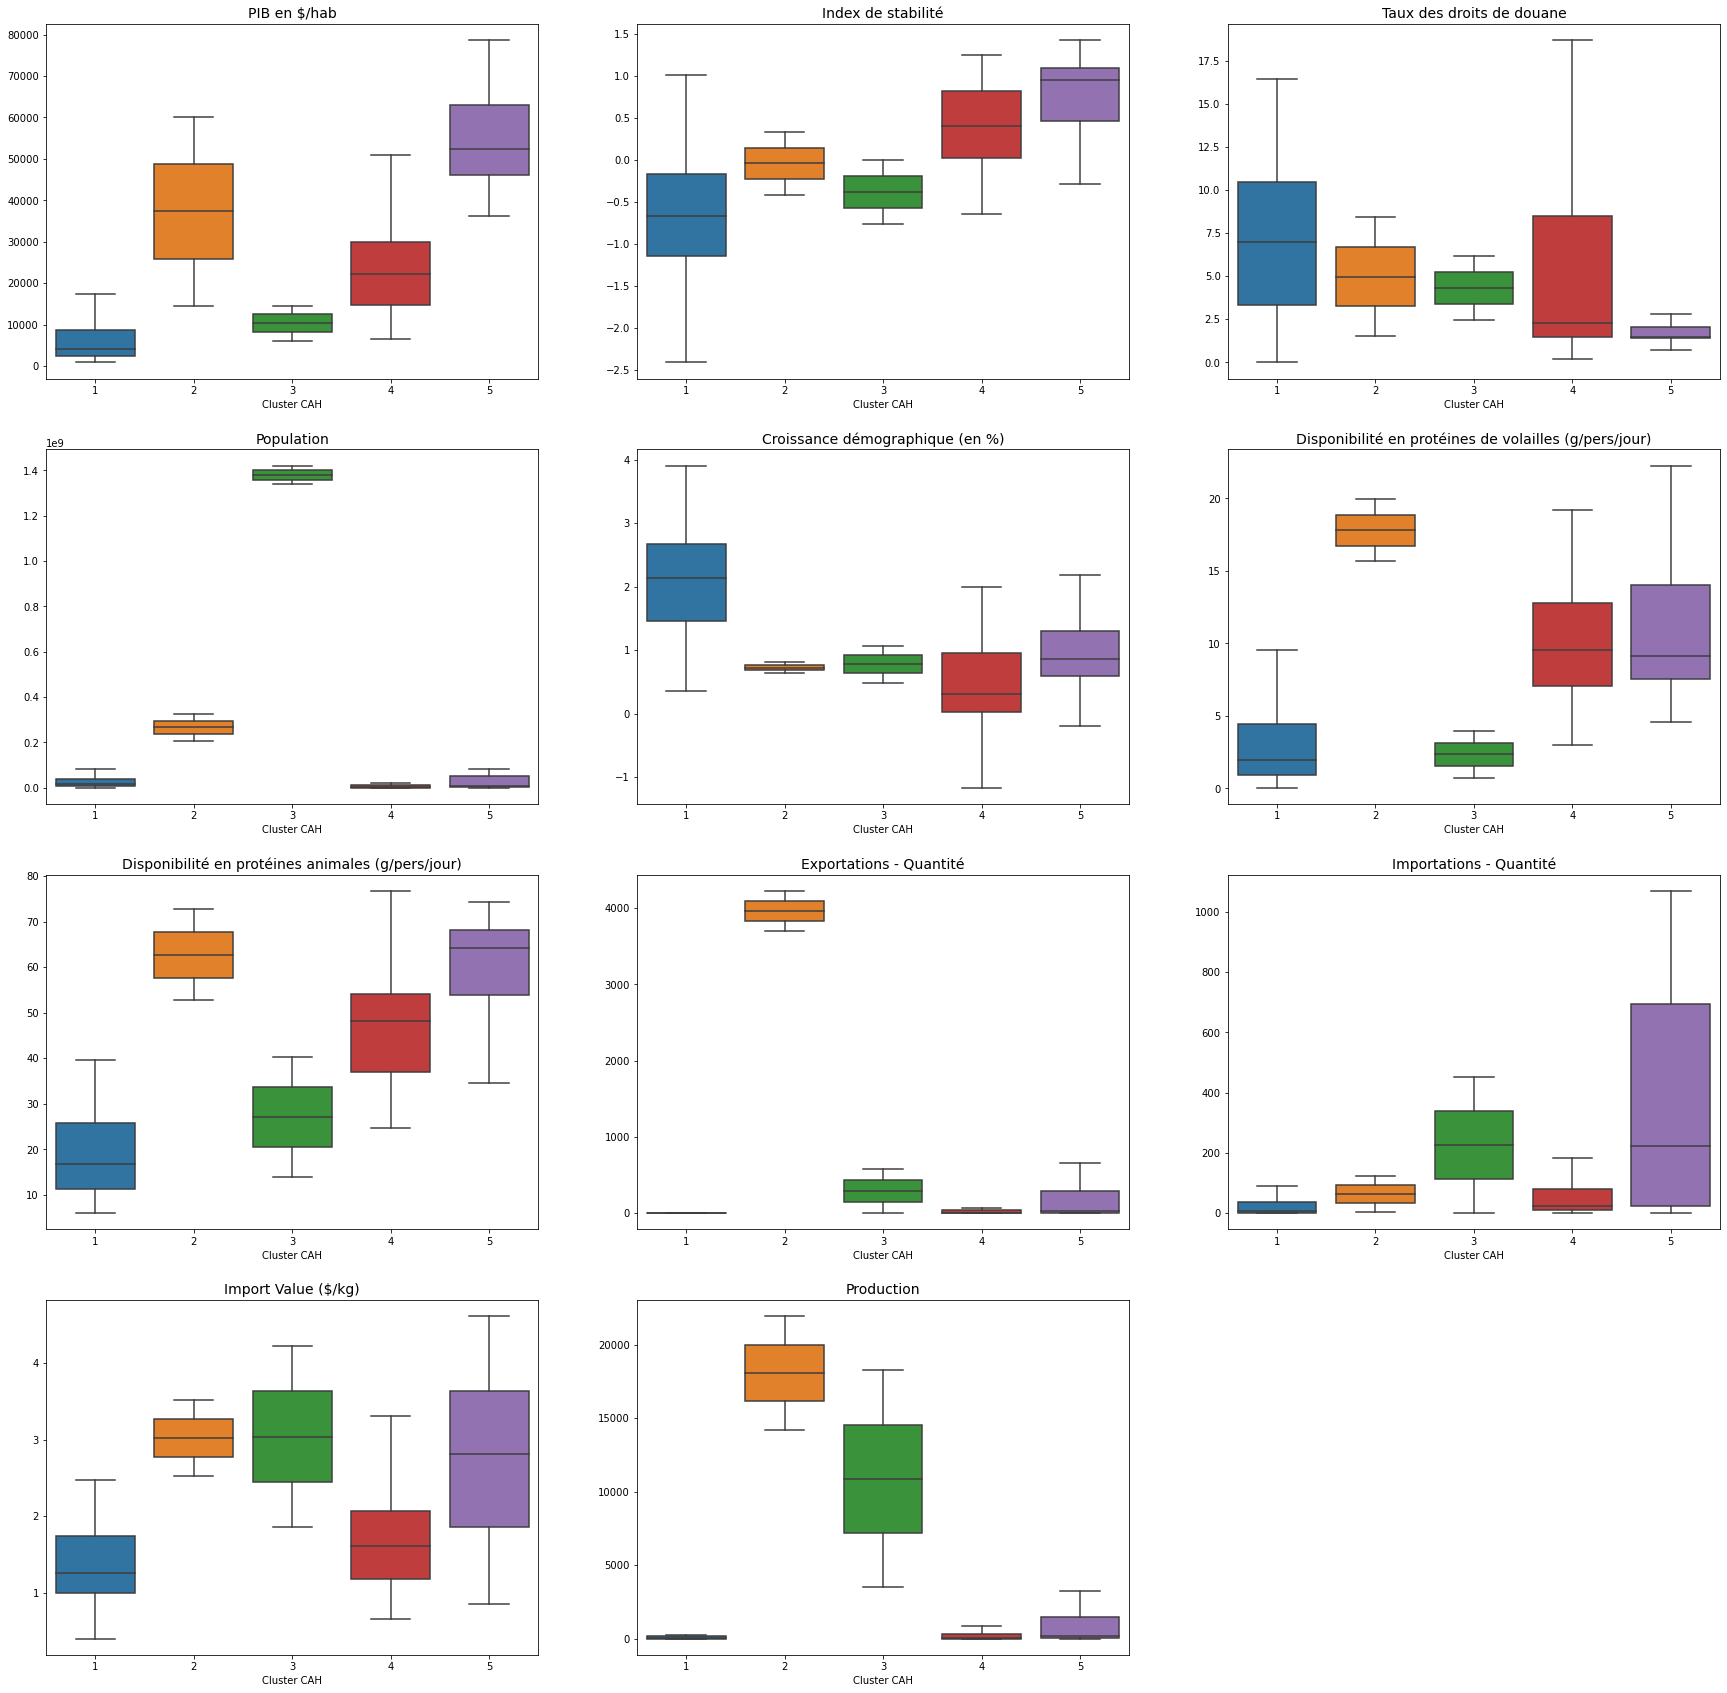

In [19]:
k = df[df.columns[:11]].values

# boxplot de chaque indicateur
fig = plt.figure(figsize=(30, 30))
for feat_idx in range(k.shape[1]):
    ax = fig.add_subplot(4, 3, (feat_idx+1))
    ax = sns.boxplot(data=df, y=k[:, feat_idx], x='Cluster CAH', showfliers=False)
    ax.set_title(df.columns[feat_idx], fontsize=14);

Pour les tests suivants nous auront besoin de la librairie scipi.<br>Notre seuil de test sera de 5%

In [20]:
from scipy.stats import levene, shapiro, f_oneway
ALPHA = 0.05

### Test d'homoscédasticité
Nous réalisons pour celà un test de Levene
> H0 : les variances sont égales<br>H1 : au moins une des variances diffère des autres

In [21]:
lev = []
for column in df:
    stat, pval = levene(df[column].loc[df["Cluster CAH"] == 1],
                        df[column].loc[df["Cluster CAH"] == 2],
                        df[column].loc[df["Cluster CAH"] == 3],
                        df[column].loc[df["Cluster CAH"] == 4],
                        df[column].loc[df["Cluster CAH"] == 5],
                        center='mean')
    H0 = "Hypothèse non rejetée" if pval > ALPHA else "Hypothèse rejetée"
    lev.append((column, stat, pval, H0))
pd.DataFrame(lev, columns=("Variable", "Stat", "p-value", "Hypothèse")).set_index("Variable")

C:\Users\miste\anaconda3\lib\site-packages\scipy\stats\morestats.py:2603: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


,Stat,p-value,Hypothèse
Variable,,,
PIB en $/hab,11.534013,3.483961e-08,Hypothèse rejetée
Index de stabilité,2.080840,8.612747e-02,Hypothèse non rejetée
Taux des droits de douane,3.512393,9.014365e-03,Hypothèse rejetée
Population,4.911807,9.511830e-04,Hypothèse rejetée
Croissance démographique (en %),1.487744,2.087488e-01,Hypothèse non rejetée
Disponibilité en protéines de volailles (g/pers/jour),3.765940,6.001614e-03,Hypothèse rejetée
Disponibilité en protéines animales (g/pers/jour),1.503649,2.040031e-01,Hypothèse non rejetée
Exportations - Quantité,13.969068,1.059267e-09,Hypothèse rejetée
Importations - Quantité,61.891188,1.010988e-30,Hypothèse rejetée


### Test de Normalité

Nous utilisons un test de Shapiro-Wilk<br>NB : les clusters {{clusterCAH2}} et {{clusterCAH3}} ne pourront être testés (N<3)
>H0 : la distribution suit une loi normale<br>H1 : la distribution ne suit pas une loi normale

In [22]:
shap = []
for i in[clusterCAH1, clusterCAH4, retenuCAH]:
    for column in df:
        dft = df[df["Cluster CAH"] == i]
        stat, pval = shapiro(dft[column])
        H0 = "Hypothèse non rejetée" if pval > ALPHA else "Hypothèse rejetée"
        shap.append((i, column, stat, pval, H0))
pd.DataFrame(shap, columns=("Cluster", "Variable", "Stat", "p-value", "Hypothèse")).set_index("Cluster")

C:\Users\miste\anaconda3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,Variable,Stat,p-value,Hypothèse
Cluster,,,,
1,PIB en $/hab,0.823567,1.471755e-07,Hypothèse rejetée
1,Index de stabilité,0.977022,2.414597e-01,Hypothèse non rejetée
1,Taux des droits de douane,0.958025,2.223049e-02,Hypothèse rejetée
1,Population,0.705636,2.211289e-10,Hypothèse rejetée
1,Croissance démographique (en %),0.974944,1.868413e-01,Hypothèse non rejetée
1,Disponibilité en protéines de volailles (g/per...,0.863137,2.373348e-06,Hypothèse rejetée
1,Disponibilité en protéines animales (g/pers/jour),0.910880,1.340599e-04,Hypothèse rejetée
1,Exportations - Quantité,0.216786,3.060354e-17,Hypothèse rejetée
1,Importations - Quantité,0.559957,5.751642e-13,Hypothèse rejetée


### Analyse de variance

Le but est de tester les moyennes de nos clusters
>H0 : les moyennes sont égales<br>H1 au moins une des moyennes diffère

In [23]:
anova = []
for column in df:
        stat, pval = f_oneway(df[column].loc[df["Cluster CAH"] == 1],
                              df[column].loc[df["Cluster CAH"] == 2],
                              df[column].loc[df["Cluster CAH"] == 3],
                              df[column].loc[df["Cluster CAH"] == 4],
                              df[column].loc[df["Cluster CAH"] == 5])
        H0 = "Hypothèse non rejetée" if pval > ALPHA else "Hypothèse rejetée"
        anova.append((column, stat, pval, H0))
pd.DataFrame(anova, columns=("Variable", "Stat", "p-value", "Hypothèse")).set_index("Variable")

C:\Users\miste\anaconda3\lib\site-packages\scipy\stats\stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


,Stat,p-value,Hypothèse
Variable,,,
PIB en $/hab,67.485533,1.746338e-32,Hypothèse rejetée
Index de stabilité,29.848785,3.104162e-18,Hypothèse rejetée
Taux des droits de douane,5.769949,2.407593e-04,Hypothèse rejetée
Population,716.134882,3.692942e-96,Hypothèse rejetée
Croissance démographique (en %),30.015453,2.588087e-18,Hypothèse rejetée
Disponibilité en protéines de volailles (g/pers/jour),40.507466,6.146375e-23,Hypothèse rejetée
Disponibilité en protéines animales (g/pers/jour),72.494964,5.508973e-34,Hypothèse rejetée
Exportations - Quantité,225.766539,3.738878e-62,Hypothèse rejetée
Importations - Quantité,19.328744,7.919182e-13,Hypothèse rejetée


Pour chaque variable, l'hypothèse H0 est rejetée, au moins une des moyennes diffèrent des autres

# Algorithme du K-means <a class="anchor" id="chapter6"></a>
## Inertie du modèle <a class="anchor" id="section6_1"></a>

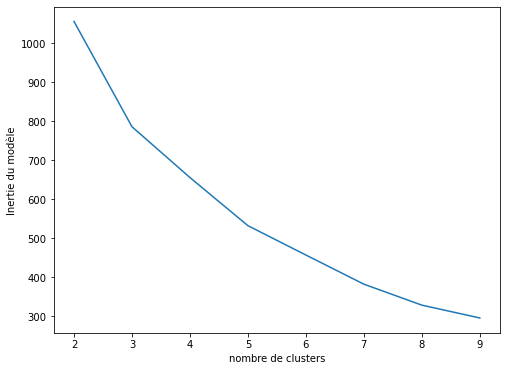

In [24]:
inertie = []

for k in range(2,10):
    model=cluster.KMeans(n_clusters=k).fit(X_trans)
    inertie.append(model.inertia_)
    
fig = plt.figure(figsize=(8,6))
plt.plot(range(2,10),inertie)
plt.xlabel('nombre de clusters')
plt.ylabel('Inertie du modèle')
plt.show();

In [25]:
from kneed import KneeLocator

kl = KneeLocator (range(2, 10), inertie, curve="convex", direction="decreasing")
print('Le nombre optimal de clusters est de', kl.elbow)

Le nombre optimal de clusters est de 5


## Coefficient de silhouette <a class="anchor" id="section6_2"></a>

,2,3,4,5,6,7,8,9
coefficient de silhouette,0.319445,0.337887,0.294294,0.309541,0.336002,0.278434,0.301343,0.312397


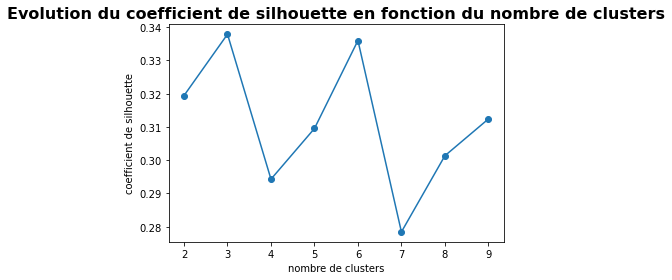

In [26]:
silhouette = []
k_range = range(2, 10)
for num_cls in range(2, 10):
    modelkm = KMeans(n_clusters = num_cls)
    modelkm.fit_predict(X_trans)
    cluster_labels = modelkm.fit_predict(X_trans)
    silh = metrics.silhouette_score(X_trans, cluster_labels)
    silhouette.append(silh)
    
plt.plot(range(2, 10), silhouette, marker = 'o')
plt.xlabel('nombre de clusters')
plt.ylabel('coefficient de silhouette')
plt.title('Evolution du coefficient de silhouette en fonction du nombre de clusters', fontsize=16, fontweight='bold')
plt.show
silhouette = pd.DataFrame(silhouette, index = np.arange(2, 10), columns=['coefficient de silhouette']).T
silhouette

Les 2 méthodes nous donnent un nombre optimal identique de 5 clusters. La part aléatoire de la 2e méthode peut donner des résultats différents (et faire apparaître un nombre de clusters de 6). Cette hypothèse a été testée mais le 6e cluster n'apporte pas d'améliorations au modèle.

<img src = 'Results/coef_silh_6.png' />

## Projection des centroides et des individus par cluster <a class="anchor" id="section6_3"></a>

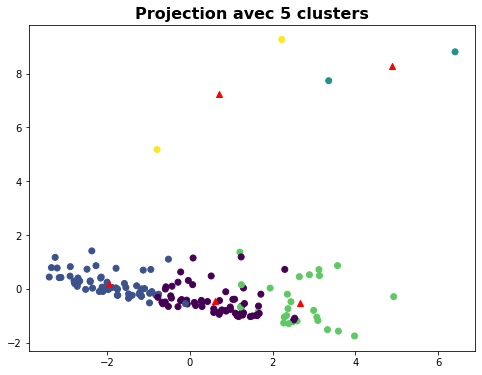

In [27]:
km5 = cluster.KMeans(n_clusters=5)
modelkm5 = km5.fit_predict(X_trans)
centroid5 = km5.cluster_centers_
# centroid5_proj = pca.transform(centroid5)

fig = plt.figure(figsize=(8,6))
plt.scatter(X_trans[:,0],X_trans[:,1], c=modelkm5)
plt.scatter(centroid5[:,0], centroid5[:,1], marker='^', c='red')
plt.title('Projection avec 5 clusters', fontsize=16, fontweight='bold');

La projection en nuage de points des 5 groupes et de leurs centroides selon l'algorithme du K-Means donnent des groupes identiques pour les pays à forte population et les pays à forte production. La classification des 3 autres groupes donnent des résultats différents

In [28]:
# ajout du cluster déterminé par K-Means au df initial
df['Cluster KM'] = km5.labels_+1
df

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Production,Cluster CAH,Cluster KM
Zone,,,,,,,,,,,,,
Afghanistan,2058.4,-2.80,5.63,3.629611e+07,2.58,0.54,10.7,0.0,29.0,1.00,28.0,1,2
Angola,7310.9,-0.33,9.23,2.981677e+07,3.38,3.60,15.7,0.0,277.0,1.12,42.0,1,2
Albanie,12771.0,0.38,1.10,2.884169e+06,-0.08,6.26,62.7,0.0,38.0,0.94,13.0,4,1
Émirats arabes unis,67183.6,0.62,3.28,9.487203e+06,1.35,14.80,50.7,94.0,433.0,1.64,48.0,5,4
Argentine,23597.1,0.17,6.88,4.393714e+07,0.99,13.53,67.3,207.0,8.0,1.86,2161.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Chine, continentale",14621.2,0.00,2.47,1.421022e+09,0.49,3.96,40.3,576.0,452.0,1.86,18236.0,3,5
Cuba,21016.6,0.65,8.83,1.133925e+07,0.04,7.12,33.0,0.0,312.0,0.95,29.0,4,1
Pérou,12506.5,-0.26,0.66,3.144430e+07,1.68,6.71,29.0,2.0,60.0,1.15,1465.0,1,1


In [29]:
km_df = df.groupby('Cluster KM').mean().drop(columns='Cluster CAH')
km_df

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Production
Cluster KM,,,,,,,,,,,
1,20051.930159,0.255079,4.204921,1.686029e+07,0.425238,9.497619,44.058730,57.825397,57.936508,1.585238,474.777778
2,5906.401639,-0.760984,8.401475,3.069694e+07,2.266230,2.930492,17.727869,8.704918,40.508197,1.622787,190.475410
3,37317.150000,-0.040000,4.965000,2.664593e+08,0.725000,17.805000,62.700000,3957.500000,63.000000,3.020000,18057.500000
4,56344.019231,0.761154,2.229231,2.721950e+07,0.898462,11.218846,63.911538,197.576923,318.461538,2.917692,691.615385
5,10402.050000,-0.380000,4.330000,1.379849e+09,0.780000,2.355000,27.150000,290.000000,226.000000,3.040000,10890.500000


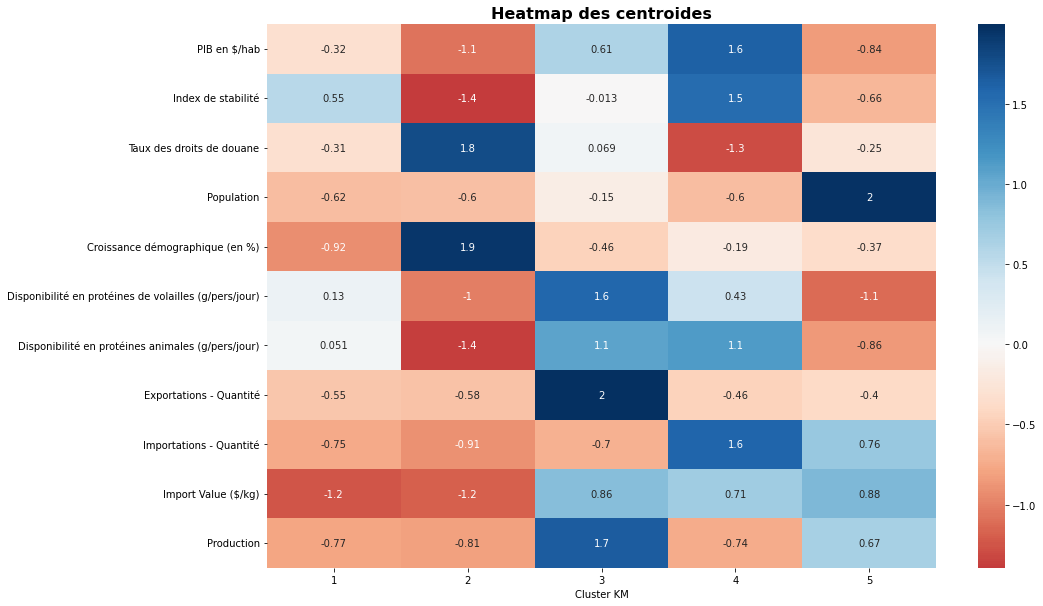

In [30]:
# les données sont centrées et réduites
km_df_scaled = scaler.fit_transform(km_df)
km_df_scaled = pd.DataFrame(km_df_scaled, index=km_df.index, columns=km_df.columns).T

fig = plt.figure(figsize=(15,10))
sns.heatmap(km_df_scaled, center=0, cmap='RdBu', annot=True)
plt.title('Heatmap des centroides', fontsize=16, fontweight='bold');

<Figure size 1080x720 with 0 Axes>

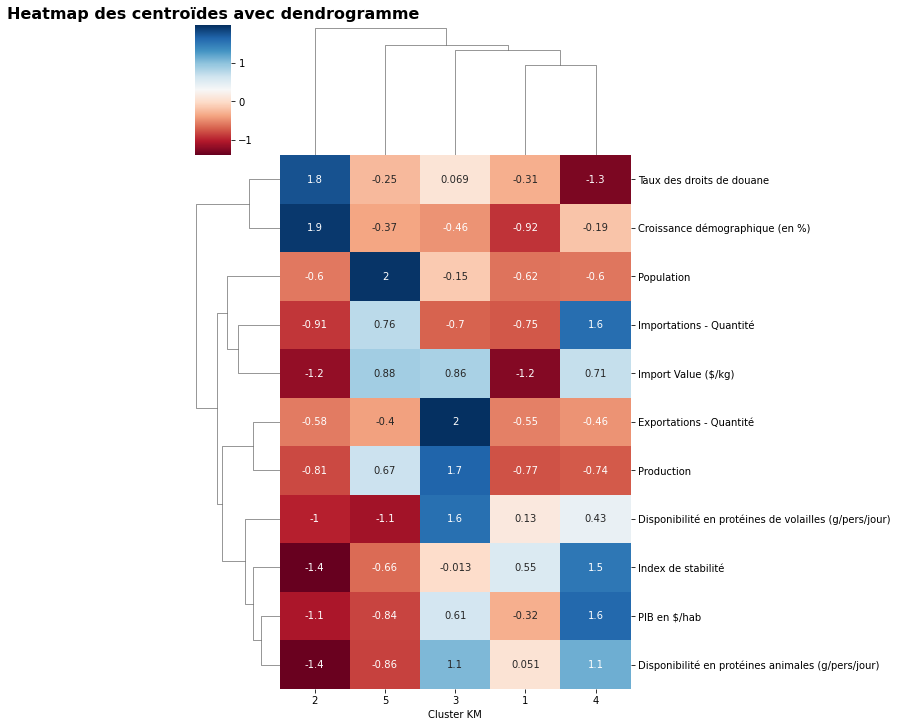

In [31]:
km_df_scaled = scaler.fit_transform(km_df)
km_df_scaled = pd.DataFrame(km_df_scaled, index=km_df.index, columns=km_df.columns).T

fig = plt.figure(figsize=(15,10))
sns.clustermap(km_df_scaled, cmap='RdBu', annot=True)
plt.title('Heatmap des centroïdes avec dendrogramme', fontsize=16, fontweight='bold');

L'initialisation de l'algorithme étant aléatoire, le numéro de cluster peut changer d'une exécution à l'autre.

In [32]:
clusterKM1 = km_df.index[km_df['PIB en $/hab'] == min(km_df['PIB en $/hab'])][0]
clusterKM2 = km_df.index[km_df['Population'] == max(km_df['Population'])][0]
clusterKM3 = km_df.index[km_df['Exportations - Quantité'] == max(km_df['Exportations - Quantité'])][0]
clusterKM4 = km_df.index[km_df['Population'] == min(km_df['Population'])][0]
retenuKM = km_df.index[km_df['Importations - Quantité'] == max(km_df['Importations - Quantité'])][0]
print('Le cluster', retenuKM,'est celui qui correspond au cluster', retenuCAH, 'trouvé par la CAH.')

Le cluster 4 est celui qui correspond au cluster 5 trouvé par la CAH.


## Analyse statistique <a class="anchor" id="section6_4"></a>
### Représentation de la distribution des variables par cluster

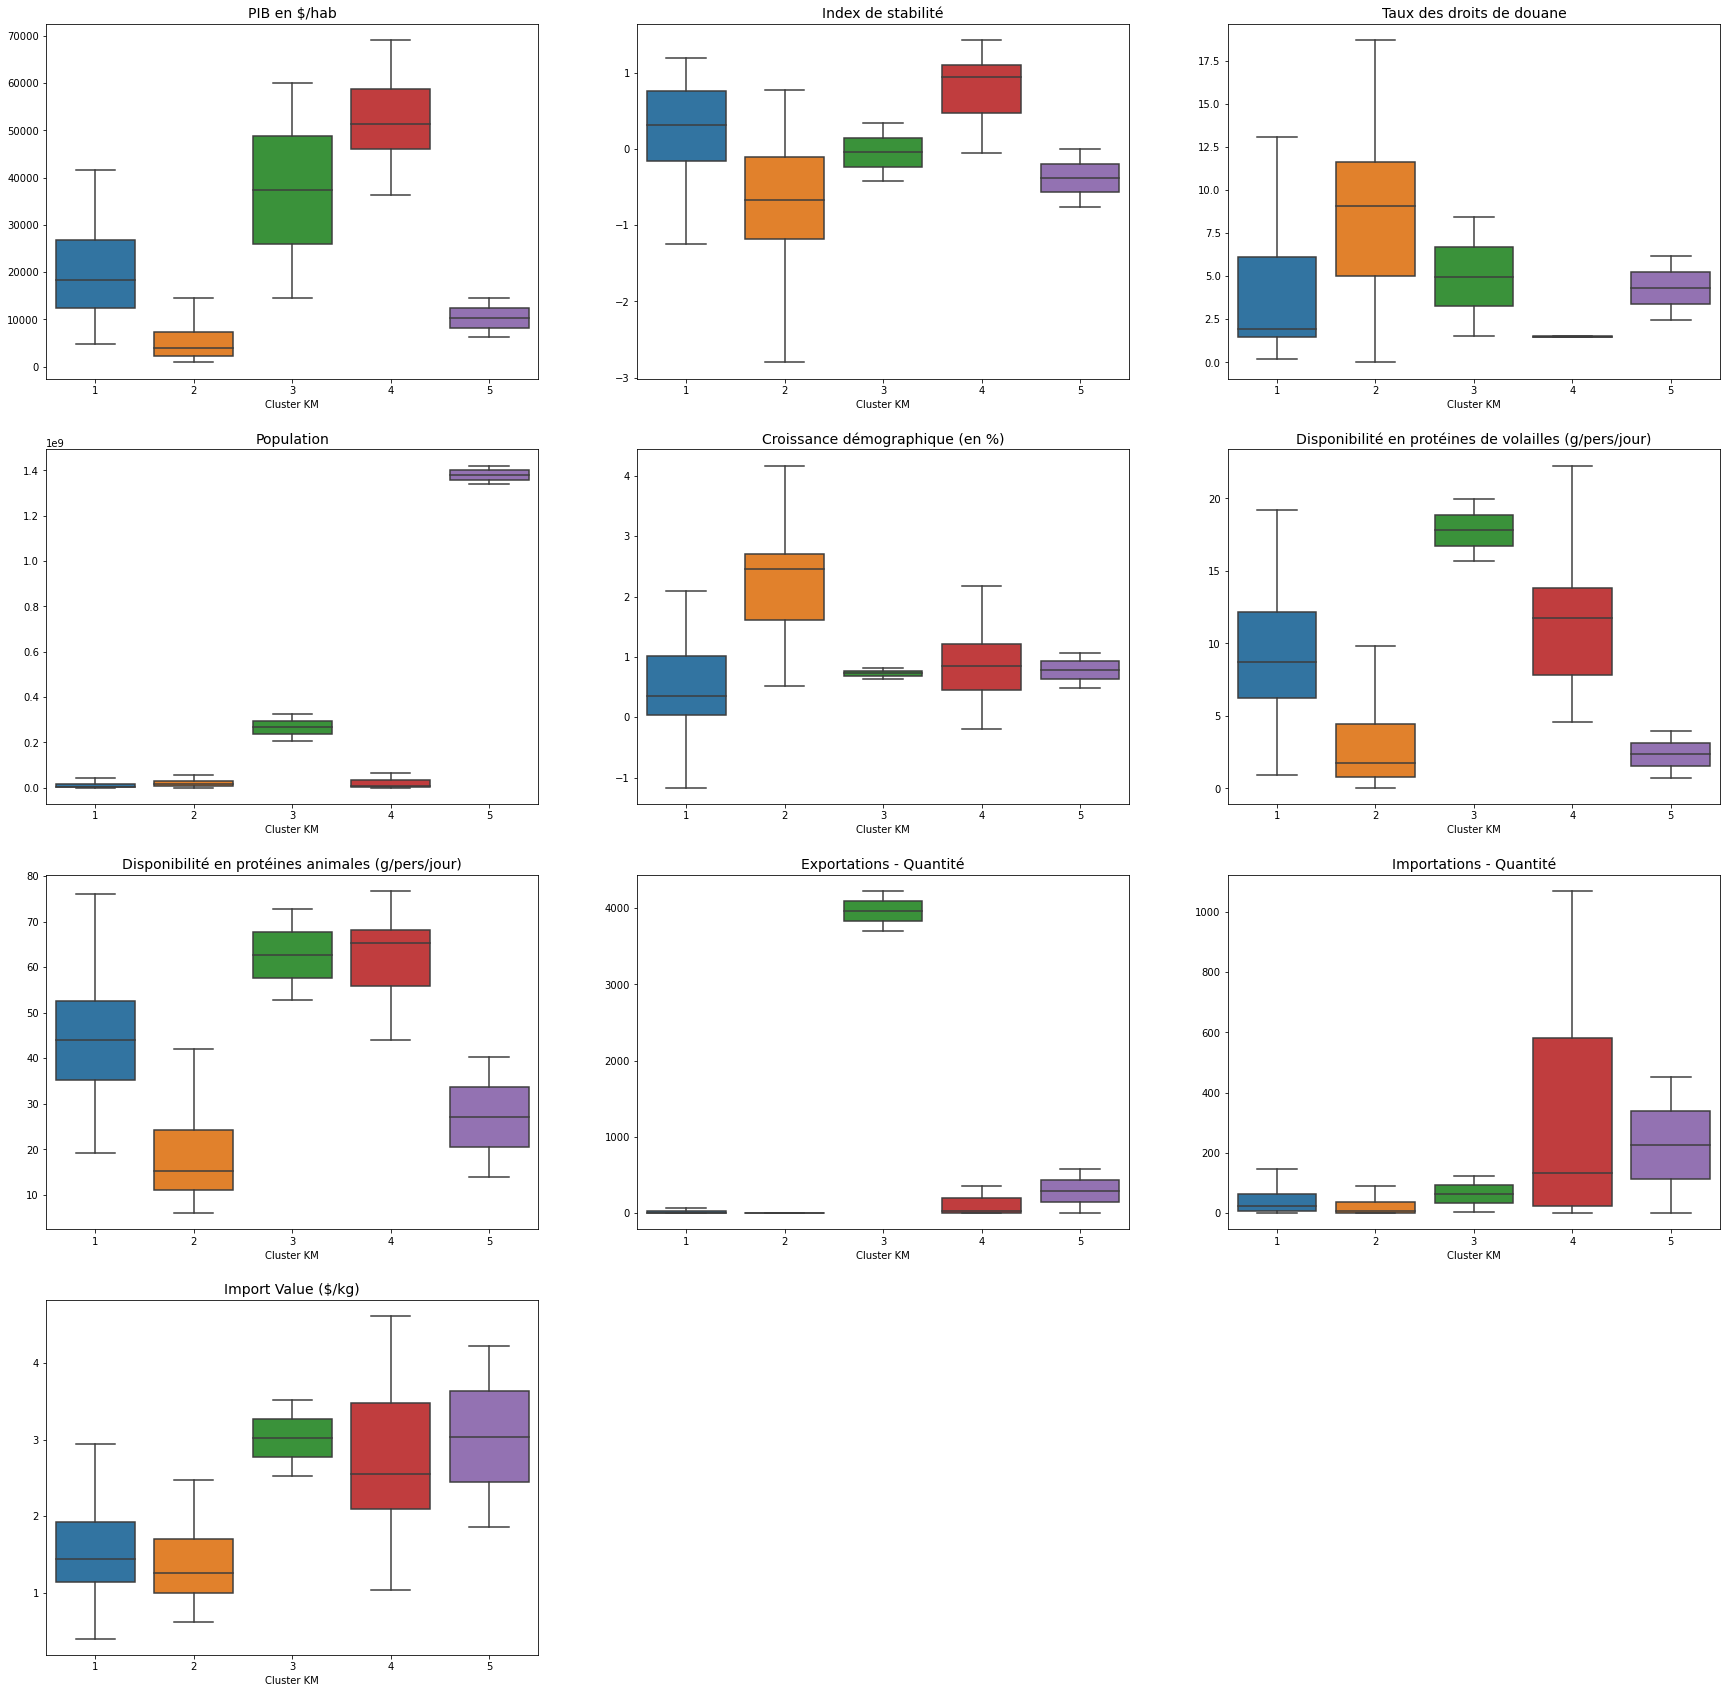

In [33]:
k = df[df.columns[:10]].values

# boxplot de chaque indicateur
fig = plt.figure(figsize=(30, 30))
for feat_idx in range(k.shape[1]):
    ax = fig.add_subplot(4, 3, (feat_idx+1))
    ax = sns.boxplot(data=df, y=k[:, feat_idx], x='Cluster KM', showfliers=False)
    ax.set_title(df.columns[feat_idx], fontsize=14);

### Test d'homoscédasticité
Nous réalisons pour celà un test de Levene
> H0 : les variances sont égales<br>H1 : au moins une des variances diffère des autres

In [34]:
lev = []
for column in df:
    stat, pval = levene(df[column].loc[df["Cluster KM"] == 1],
                        df[column].loc[df["Cluster KM"] == 2],
                        df[column].loc[df["Cluster KM"] == 3],
                        df[column].loc[df["Cluster KM"] == 4],
                        df[column].loc[df["Cluster KM"] == 5],
                        center='mean')
    H0 = "Hypothèse non rejetée" if pval > ALPHA else "Hypothèse rejetée"
    lev.append((column, stat, pval, H0))
pd.DataFrame(lev, columns=("Variable", "Stat", "p-value", "Hypothèse")).set_index("Variable")

C:\Users\miste\anaconda3\lib\site-packages\scipy\stats\morestats.py:2603: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


,Stat,p-value,Hypothèse
Variable,,,
PIB en $/hab,9.382299,8.621167e-07,Hypothèse rejetée
Index de stabilité,1.501014,2.047826e-01,Hypothèse non rejetée
Taux des droits de douane,3.845119,5.284825e-03,Hypothèse rejetée
Population,2.326132,5.899436e-02,Hypothèse non rejetée
Croissance démographique (en %),1.374134,2.456302e-01,Hypothèse non rejetée
Disponibilité en protéines de volailles (g/pers/jour),3.355854,1.158205e-02,Hypothèse rejetée
Disponibilité en protéines animales (g/pers/jour),2.450670,4.859178e-02,Hypothèse rejetée
Exportations - Quantité,13.737875,1.466714e-09,Hypothèse rejetée
Importations - Quantité,42.273732,1.176142e-23,Hypothèse rejetée


### Test de Normalité

Nous utilisons un test de Shapiro-Wilk<br>NB : les clusters {{clusterCAH2}} et {{clusterCAH3}} ne pourront être testés (N<3)
>H0 : la distribution suit une loi normale<br>H1 : la distribution ne suit pas une loi normale

In [35]:
shap = []
for i in[clusterKM1, clusterKM4, retenuKM]:
    for column in df:
        dft = df[df["Cluster KM"] == i]
        stat, pval = shapiro(dft[column])
        H0 = "Hypothèse non rejetée" if pval > ALPHA else "Hypothèse rejetée"
        shap.append((i, column, stat, pval, H0))
pd.DataFrame(shap, columns=("Cluster", "Variable", "Stat", "p-value", "Hypothèse")).set_index("Cluster")

C:\Users\miste\anaconda3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,Variable,Stat,p-value,Hypothèse
Cluster,,,,
2,PIB en $/hab,0.727715,2.572511e-09,Hypothèse rejetée
2,Index de stabilité,0.965798,8.589281e-02,Hypothèse non rejetée
2,Taux des droits de douane,0.978983,3.760674e-01,Hypothèse non rejetée
2,Population,0.653823,1.005913e-10,Hypothèse rejetée
2,Croissance démographique (en %),0.973242,2.013106e-01,Hypothèse non rejetée
2,Disponibilité en protéines de volailles (g/per...,0.848884,2.414795e-06,Hypothèse rejetée
2,Disponibilité en protéines animales (g/pers/jour),0.917344,5.371608e-04,Hypothèse rejetée
2,Exportations - Quantité,0.143562,4.595568e-17,Hypothèse rejetée
2,Importations - Quantité,0.551840,2.298239e-12,Hypothèse rejetée


### Analyse de variance

Le but est de tester les moyennes de nos clusters
>H0 : les moyennes sont égales<br>H1 au moins une des moyennes diffère

In [36]:
anova = []
for column in df:
        stat, pval = f_oneway(df[column].loc[df["Cluster KM"] == 1],
                              df[column].loc[df["Cluster KM"] == 2],
                              df[column].loc[df["Cluster KM"] == 3],
                              df[column].loc[df["Cluster KM"] == 4],
                              df[column].loc[df["Cluster KM"] == 5])
        H0 = "Hypothèse non rejetée" if pval > ALPHA else "Hypothèse rejetée"
        anova.append((column, stat, pval, H0))
pd.DataFrame(anova, columns=("Variable", "Stat", "p-value", "Hypothèse")).set_index("Variable")

C:\Users\miste\anaconda3\lib\site-packages\scipy\stats\stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


,Stat,p-value,Hypothèse
Variable,,,
PIB en $/hab,85.425351,1.444660e-37,Hypothèse rejetée
Index de stabilité,26.495515,1.324624e-16,Hypothèse rejetée
Taux des droits de douane,14.506219,4.997606e-10,Hypothèse rejetée
Population,682.063070,1.157945e-94,Hypothèse rejetée
Croissance démographique (en %),46.404882,2.817857e-25,Hypothèse rejetée
Disponibilité en protéines de volailles (g/pers/jour),34.293677,2.806354e-20,Hypothèse rejetée
Disponibilité en protéines animales (g/pers/jour),84.022283,3.386839e-37,Hypothèse rejetée
Exportations - Quantité,228.043700,1.969825e-62,Hypothèse rejetée
Importations - Quantité,14.319669,6.482253e-10,Hypothèse rejetée


Pour chaque variable, l'hypothèse H0 est rejetée, au moins une des moyennes diffèrent des autres<br>Nos clusters sont différents les uns des autres

# Comparaison des résultats <a class="anchor" id="chapter7"></a>

Les deux algorithmes utilisés ont chacun fait ressortir un groupe-cible à privilégier.<br>Comparons maintenant ces 2 groupes

In [37]:
df_cluster_cah = df.loc[df['Cluster CAH'] == retenuCAH]
df_cluster_cah

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Production,Cluster CAH,Cluster KM
Zone,,,,,,,,,,,,,
Émirats arabes unis,67183.6,0.62,3.28,9487203.0,1.35,14.80,50.7,94.0,433.0,1.64,48.0,5,4
Australie,48482.6,0.89,0.71,24584620.0,1.33,16.60,71.6,42.0,16.0,4.46,1269.0,5,4
Autriche,54170.0,1.05,1.48,8819901.0,0.83,7.49,64.7,78.0,110.0,3.40,148.0,5,4
Belgique,50442.3,0.43,1.48,11419748.0,0.58,4.57,58.3,656.0,338.0,1.56,463.0,5,4
Bahamas,36298.4,0.99,17.05,381755.0,1.01,14.61,52.3,0.0,24.0,7.31,6.0,5,4
Suisse,69103.6,1.26,1.36,8455804.0,0.91,6.49,60.0,4.0,51.0,3.76,91.0,5,4
Allemagne,52952.9,0.59,1.48,82658409.0,0.57,7.96,63.0,646.0,842.0,2.32,1514.0,5,4
Finlande,47570.1,1.08,1.48,5511371.0,0.25,7.87,74.3,12.0,16.0,3.90,129.0,5,4
France,44577.1,0.28,1.48,64842509.0,0.27,8.95,63.7,501.0,506.0,2.54,1750.0,5,4


Les 21 pays de notre cluster se retrouvent bien dans le même groupe à l'exception de l'Afrique du Sud, pour laquelle les valeurs de PIB/hab et de taux des droits de douane sont différents des autres pays du groupe ce qu'a pris en compte le K-Means.

In [38]:
df_cluster_km = df.loc[df['Cluster KM'] == retenuKM]
df_cluster_km

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Production,Cluster CAH,Cluster KM
Zone,,,,,,,,,,,,,
Émirats arabes unis,67183.6,0.62,3.28,9487203.0,1.35,14.80,50.7,94.0,433.0,1.64,48.0,5,4
Australie,48482.6,0.89,0.71,24584620.0,1.33,16.60,71.6,42.0,16.0,4.46,1269.0,5,4
Autriche,54170.0,1.05,1.48,8819901.0,0.83,7.49,64.7,78.0,110.0,3.40,148.0,5,4
Belgique,50442.3,0.43,1.48,11419748.0,0.58,4.57,58.3,656.0,338.0,1.56,463.0,5,4
Bahamas,36298.4,0.99,17.05,381755.0,1.01,14.61,52.3,0.0,24.0,7.31,6.0,5,4
Canada,48317.1,1.10,1.49,36732095.0,0.96,13.86,55.0,163.0,182.0,2.36,1417.0,4,4
Suisse,69103.6,1.26,1.36,8455804.0,0.91,6.49,60.0,4.0,51.0,3.76,91.0,5,4
Allemagne,52952.9,0.59,1.48,82658409.0,0.57,7.96,63.0,646.0,842.0,2.32,1514.0,5,4
Danemark,55356.7,0.87,1.48,5732274.0,0.37,12.97,76.7,139.0,133.0,3.10,173.0,4,4


Le cluster prédit par K-Means est plus grand. Il contient 5 pays du cluster {{clusterCAH4}}. Ces pays semblent remplir les critères que nous recherchons.<br> Il peut-être intéressant de créer un groupe contenant les pays présents dans les 2 clusters et de voir les sous-groupes qui s'en dégagent.
## Analyse des sous-groupes <a class="anchor" id="section7_2"></a>
Nous créons donc un dataframe réunissant nos 2 groupes puis nous supprimons les doublons

In [39]:
# df des 27 pays retenus par CAH ou KM 
group = pd.concat([df_cluster_cah, df_cluster_km]).drop(columns=['Cluster CAH', 'Cluster KM']).drop_duplicates()
# création d'un tableau numpy 2D
Xg = group.values
# les index sont stockés dans un objet names
namesXg = group.index
# normalisation
Xg_scaled = scaler.fit_transform(Xg)

Classification Ascendante Hiérarchique

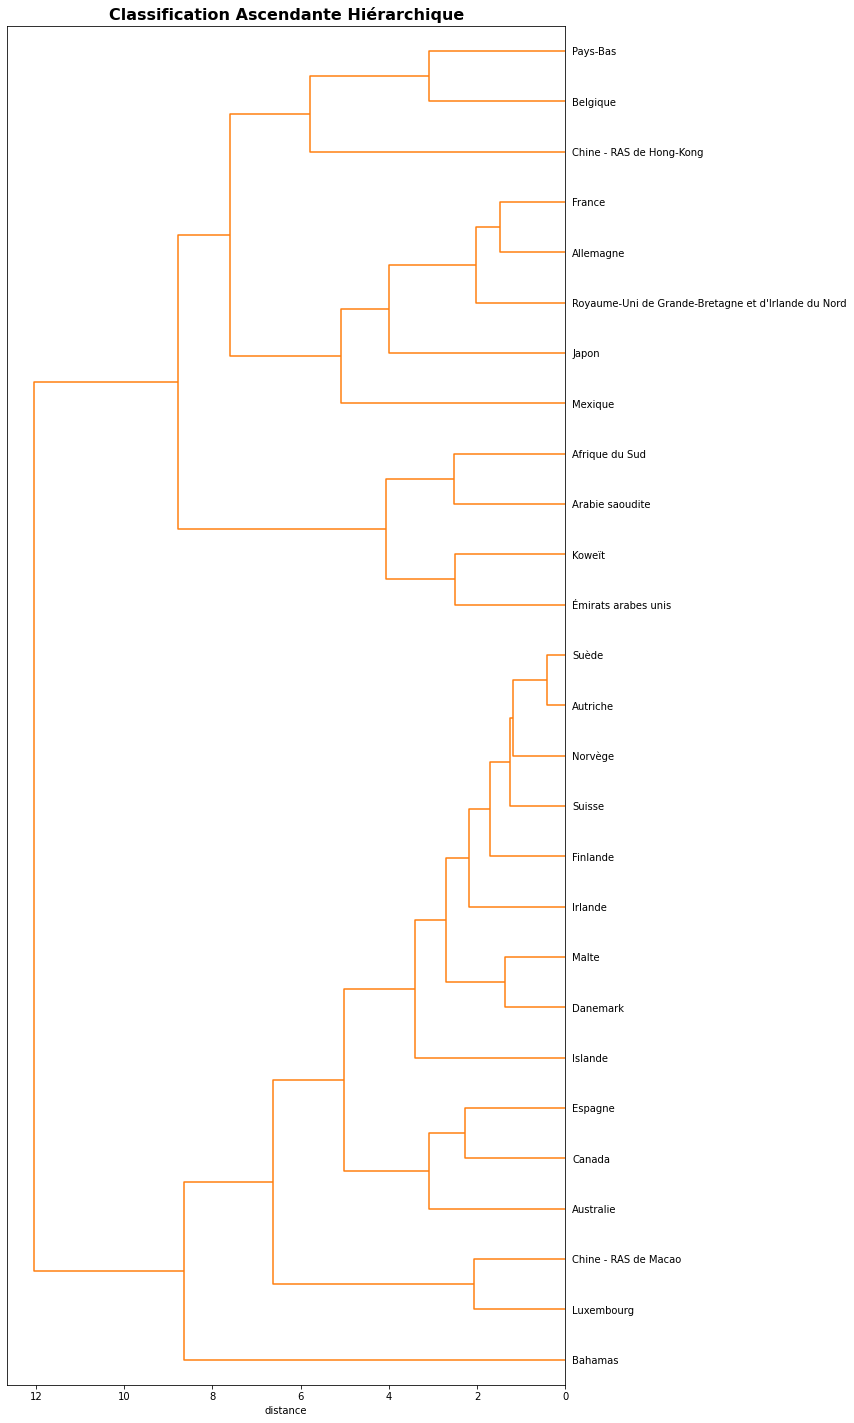

In [40]:
Zg = linkage(Xg_scaled, 'ward')

plot_dendrogram(Zg, namesXg, 'left')

In [41]:
clusters2 = fcluster(Zg, 2, criterion='maxclust')
group['Sous-groupe CAH'] = clusters2

Algorithme du K-Means

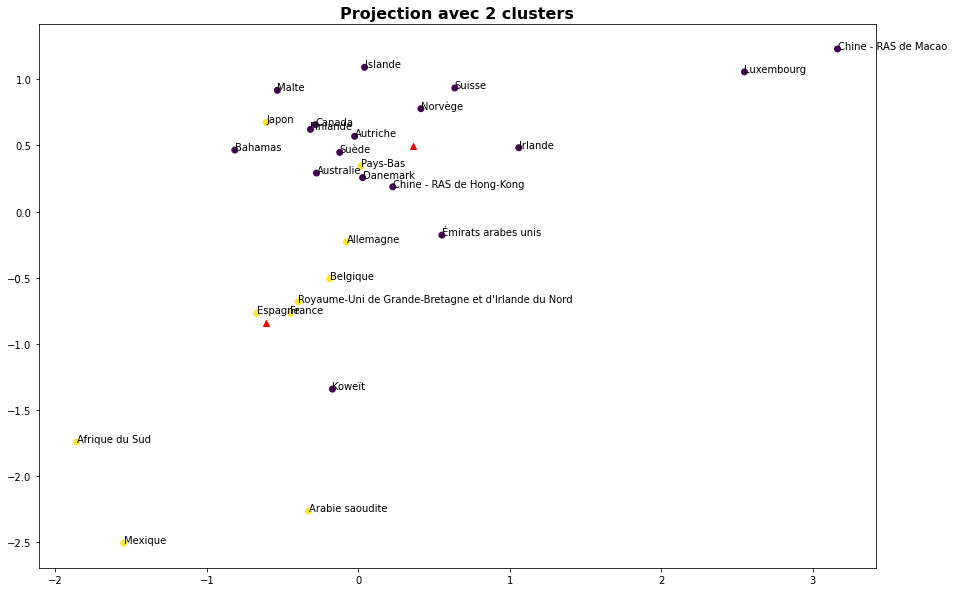

In [42]:
# K-Means avec 2 clusters
km2 = cluster.KMeans(n_clusters=2)
modelkm2 = km2.fit_predict(Xg_scaled)
centroid2 = km2.cluster_centers_

fig = plt.figure(figsize=(15,10))
plt.scatter(Xg_scaled[:,0], Xg_scaled[:,1], c=modelkm2)
for i, label in enumerate(namesXg):
    plt.annotate(label, (Xg_scaled[:,0][i], Xg_scaled[:,1][i]))
plt.scatter(centroid2[:,0], centroid2[:,1], marker='^', c='red')
plt.title('Projection avec 2 clusters', fontsize=16, fontweight='bold');

In [43]:
group['Sous-groupe KM'] = km2.labels_+1
group

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Production,Sous-groupe CAH,Sous-groupe KM
Zone,,,,,,,,,,,,,
Émirats arabes unis,67183.6,0.62,3.28,9487203.0,1.35,14.80,50.7,94.0,433.0,1.64,48.0,2,1
Australie,48482.6,0.89,0.71,24584620.0,1.33,16.60,71.6,42.0,16.0,4.46,1269.0,1,1
Autriche,54170.0,1.05,1.48,8819901.0,0.83,7.49,64.7,78.0,110.0,3.40,148.0,1,1
Belgique,50442.3,0.43,1.48,11419748.0,0.58,4.57,58.3,656.0,338.0,1.56,463.0,2,2
Bahamas,36298.4,0.99,17.05,381755.0,1.01,14.61,52.3,0.0,24.0,7.31,6.0,1,1
Suisse,69103.6,1.26,1.36,8455804.0,0.91,6.49,60.0,4.0,51.0,3.76,91.0,1,1
Allemagne,52952.9,0.59,1.48,82658409.0,0.57,7.96,63.0,646.0,842.0,2.32,1514.0,2,2
Finlande,47570.1,1.08,1.48,5511371.0,0.25,7.87,74.3,12.0,16.0,3.90,129.0,1,1
France,44577.1,0.28,1.48,64842509.0,0.27,8.95,63.7,501.0,506.0,2.54,1750.0,2,2


Notre cluster se divise en 2 sous-groupes, celui contenant la France sera à privilégier.<br>Les pays du second sous-groupe constitue un pool de pays potentiels pour d'autres extensions à l'International.

# Projection sur les plans factoriels <a class="anchor" id="chapter8"></a>
## Projection des 5 clusters

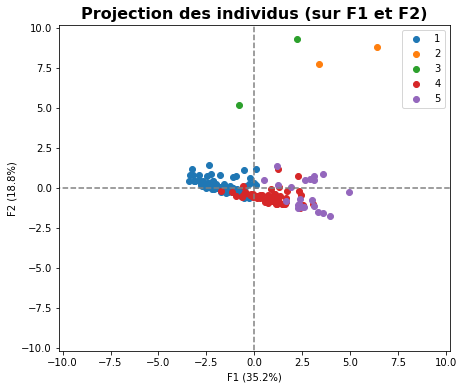

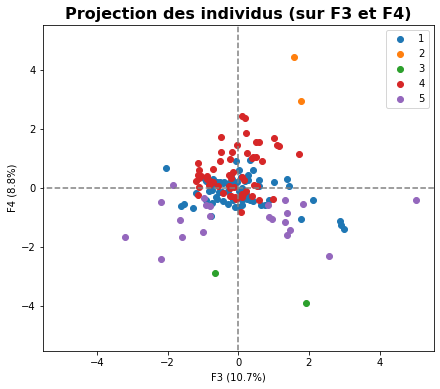

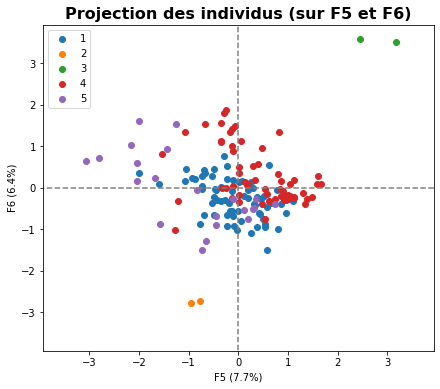

In [44]:
# projection de X sur les composantes principales
X_projected = pca.transform(X_scaled)

display_factorial_planes (X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], illustrative_var = clusters, labels=None)

Les clusters sont bien distincts selon la projection sur F1 et F2, les clusters {{clusterCAH2}} et {{clusterCAH3}} montrent bien l'influence forte des variables Production et Population sur la 2e CP. Sur la 2e projection, nous remarquons aussi l'effet antagoniste qu'on ces variables sur la 4e CP.
## Projection des 2 sous-groupes <a class="anchor" id="section8_2"></a>

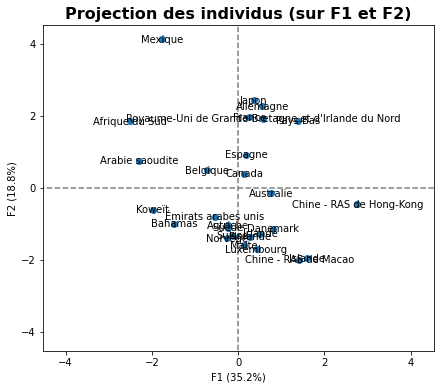

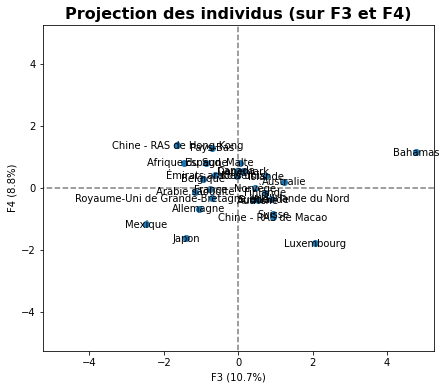

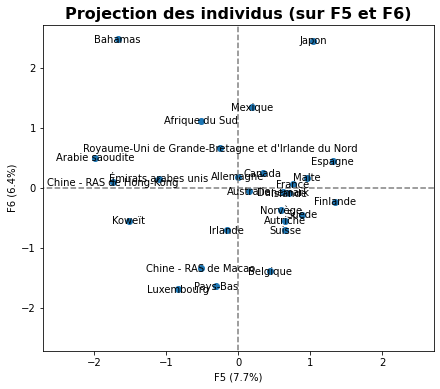

In [45]:
# projection de Xg sur les composantes principales
Xg_projected = pca.transform(Xg_scaled)

display_factorial_planes (Xg_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels=namesXg)

# Création de cartes <a class="anchor" id="chapter 9"></a>
Pour la création de cartes, nous utiliserons la librairie folium.<br>Nous utiliserons les codes ISO3 et un fichier json pour créer un polygone pour chaque pays

In [46]:
import folium as f

# importation pour la création de cartes
pays_geo = 'Data/world_countries.json'
code = pd.read_csv("Data/ISO_pays_fr.csv")

# intégration d'une colonne id aux df
df_cah_map = df_cluster_cah.merge(code, on="Zone", how="inner")
df_km_map = df_cluster_km.merge(code, on="Zone", how="inner")

## Création d'une carte des pays retenus par la CAH

In [47]:
# création d'une carte vierge
m = f.Map(location=[0, 20], zoom_start=2)

# création de la carte choroplèthe
choro1 = f.Choropleth(geo_data=pays_geo,
                          name="clusters",
                          data=df_cah_map,
                          columns=["id", "Cluster CAH"],
                          key_on="feature.id",
                          fill_color="YlOrRd",
                          fill_opacity=0.7,
                          nan_fill_color="grey",
                          nan_fill_opacity=0.05,
                          line_opacity=0.2).add_to(m)

# pour ne pas afficher la légende
for key in choro1._children:
    if key.startswith('color_map'):
        del(choro1._children[key])
        
m

## Création d'une carte des pays retenus par K-means

In [48]:
# création de la carte choroplèthe
choro2 = f.Choropleth(geo_data=pays_geo,
                          name="clusters",
                          data=df_km_map,
                          columns=["id", "Cluster KM"],
                          key_on="feature.id",
                          fill_color="YlOrRd",
                          fill_opacity=0.7,
                          nan_fill_color="grey",
                          nan_fill_opacity=0.05,
                          line_opacity=0.2).add_to(m)

# pour ne pas afficher la légende
for key in choro2._children:
    if key.startswith('color_map'):
        del(choro2._children[key])

m

## Création d'une carte du cluster choisi avec ses sous-groupes :

In [49]:
# variables groupes prioritaires basés sur le numéro de groupe de la France
sous_groupCAH = group['Sous-groupe CAH']['France']
sous_groupKM = group['Sous-groupe KM']['France']

# changement de groupe : 0 pour le groupe secondaire, 1 pour le groupe prioritaire
group['Sous-groupe CAH'] = group['Sous-groupe CAH'].apply(lambda x: 0 if x != sous_groupCAH else x)
group['Sous-groupe CAH'] = group['Sous-groupe CAH'].apply(lambda x: 1 if x == sous_groupCAH else x)

group['Sous-groupe KM'] = group['Sous-groupe KM'].apply(lambda x: 0 if x != sous_groupKM else x)
group['Sous-groupe KM'] = group['Sous-groupe KM'].apply(lambda x: 1 if x == sous_groupKM else x)
group['note'] = group['Sous-groupe CAH'] + group['Sous-groupe KM']
group_map = group.merge(code, on='Zone', how='inner')

# création de la carte choroplèthe
choropleth = f.Choropleth(geo_data=pays_geo,
                          name="sous-groupe",
                          data=group_map,
                          columns=["id", "note"],
                          key_on="feature.id",
                          fill_color="YlOrRd",
                          fill_opacity=0.7,
                          nan_fill_color="grey",
                          nan_fill_opacity=0.05,
                          line_opacity=0.2).add_to(m)

# pour ne pas afficher la légende
for key in choropleth._children:
    if key.startswith('color_map'):
        del(choropleth._children[key])

m

en rouge : les pays appartenant au sous-groupe prioritaire avec les 2 méthodes<br>en orange : les pays appartenant au sous-groupe prioritaire avec l'une des méthodes<br>en jaune : les pays du sous-groupe secondaire